In [1]:
from utils import plot_scatter_by_z_levels
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pygad

# 1- SNPO

In [2]:
n_generations = 100
population_size = 100
n_modes = 12

# Set up the genetic algorithm parameters
num_parents_mating = 10

sol_per_pop = 10  # solutions per iteration

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 20

In [3]:
# Load from CSV
filtered_coord = np.loadtxt("filtered_coords.csv", delimiter=",", dtype=str)
possible_sensors_ids = filtered_coord[:,0]

print(filtered_coord, possible_sensors_ids)

[['1' '35387.0' '16225.0' '7200.0']
 ['2' '35387.0' '15505.0' '7200.0']
 ['5' '33290.0' '15505.0' '7200.0']
 ...
 ['5086' '29515.0' '18925.0' '19800.0']
 ['5087' '29515.0' '18925.0' '15600.0']
 ['5088' '29515.0' '18925.0' '11400.0']] ['1' '2' '5' ... '5086' '5087' '5088']


In [4]:
PHI_flat = np.loadtxt('ALL_SENSORS_MODE_SHAPES.csv', delimiter=',')  # shape (12, 3*n)

In [5]:
# Determine n (number of slices along the last dimension)
n = PHI_flat.shape[1] // 3

# Reshape
PHI = PHI_flat.reshape(12, 3, n)
PHI.shape

(12, 3, 3087)

The **MAC** is used to compare mode shapes and evaluate their similarity.

### 📐 MAC Equation:
$$
\text{MAC}_{ij} = \frac{|\phi_i^T \phi_j|^2}{(\phi_i^T \phi_i)(\phi_j^T \phi_j)}
$$

Explanation of Each Term:
$\phi_i$: Mode shape vector $i$

$\phi_j$: Mode shape vector $j$

$\phi_i^T\phi_j$: Dot product of the two vectors

$|\cdot|^2$: Square of the magnitude

The result is a value between 0 (completely different) and 1 (identical).

In [6]:
num_genes = PHI.shape[2]  # maximum number of genes

init_range_low = 0
init_range_high = PHI.shape[2]

In [7]:
def MAC(phi_A, phi_B):
    # Ensure phi_A and phi_B are numpy arrays
    phi_A = np.array(phi_A)
    phi_B = np.array(phi_B)
    
    # Number of modes and measurement points
    n_modes_A, n_points_A = phi_A.shape
    n_modes_B, n_points_B = phi_B.shape
    
    # Initialize the MAC matrix
    MAC_matrix = np.zeros((n_modes_A, n_modes_B))
    
    # Compute the MAC values
    for i in range(n_modes_A):
        for j in range(n_modes_B):
            numerator = np.abs(np.dot(phi_A[i, :], phi_B[j, :]))**2
            denominator = (np.dot(phi_A[i, :], phi_A[i, :]) * np.dot(phi_B[j, :], phi_B[j, :]))
            MAC_matrix[i, j] = numerator / denominator
    
    return MAC_matrix

In [8]:

def fitness_func(ga_instance, solution, solution_idx):
    solution = np.delete(solution, solution==-1)
    solution = np.unique(solution)
    phi = PHI[:, :, solution]
    mac = MAC(phi.reshape((n_modes, -1)), phi.reshape((n_modes, -1)))
    np.fill_diagonal(mac, 0)

    # Calculate the sum of non-diagonal elements
    sum_non_diagonal = np.sum(mac)
    num_parameters = len(solution)
    
    # Penalty for using more parameters
    penalty = num_parameters / num_genes  # Adjust this factor as needed
    fitness = 1 / np.sqrt(sum_non_diagonal) / (1 + penalty)

    # print("Sum of non-diagonal elements:", sum_non_diagonal)
    # print('Number of parameters:' ,num_parameters)
    # print('penalty :', penalty)
    # print('-----------------------------------------')
    return fitness

In [9]:
# Create a custom initialization function for fixed-length solutions with zeros for unused parameters
def custom_initialization(num_solutions, num_genes, init_range_low, init_range_high):
    population = []
    for _ in range(num_solutions):
        solution = np.ones(num_genes, dtype=int) * -1
        num_active_genes = np.random.randint(1, num_genes + 1)
        active_positions = np.random.choice(range(num_genes), num_active_genes, replace=False)
        active_values = np.random.choice(range(init_range_low, init_range_high), num_active_genes, replace=False)
        solution[active_positions] = active_values
        population.append(solution)
    return np.array(population)

In [10]:



progress_bar = tqdm(total=n_generations, desc='GA Progress')

def on_generation(ga_instance):
    # Update the progress bar
    progress_bar.update(1)

# Initialize the GA instance with a custom initialization function
ga_instance = pygad.GA(
    num_generations=n_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    parent_selection_type=parent_selection_type,
    keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    gene_type=int,
    on_generation=on_generation,
    initial_population=custom_initialization(population_size, num_genes, init_range_low, init_range_high)
)
print('===============OPTIMIZATION=========================')

# Run the genetic algorithm
ga_instance.run()
progress_bar.close()


GA Progress:   0%|          | 0/100 [00:00<?, ?it/s]

===============OPTIMIZATION=========================


GA Progress: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


In [11]:
final_solution, solution_fitness, solution_idx = ga_instance.best_solution()
print('Final number of sensors :', len(np.unique(final_solution)))

Final number of sensors : 182


c:\CONDA\envs\BridgeFC\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


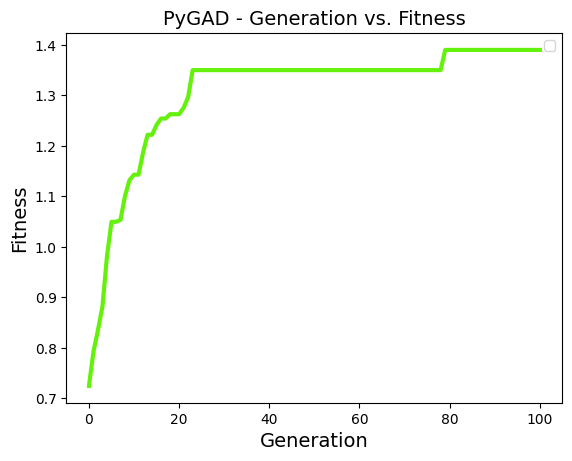

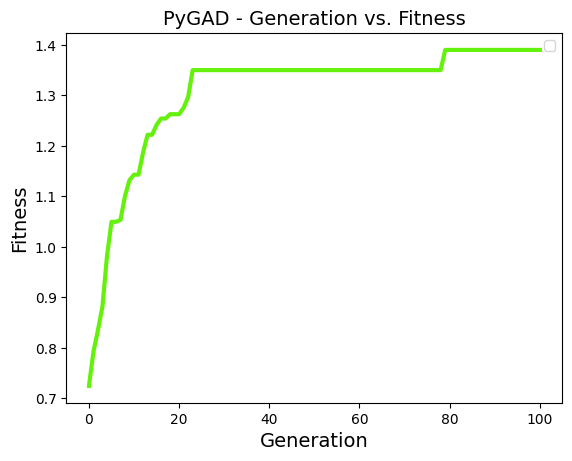

In [12]:
ga_instance.plot_fitness()

In [13]:
selected_indices = final_solution[(final_solution != 0) & (final_solution != -1)]
selected_ids = [possible_sensors_ids[i] for i in selected_indices]

# Filter rows where first column matches selected_ids
matched_rows = np.array([row for row in filtered_coord if row[0] in selected_ids])

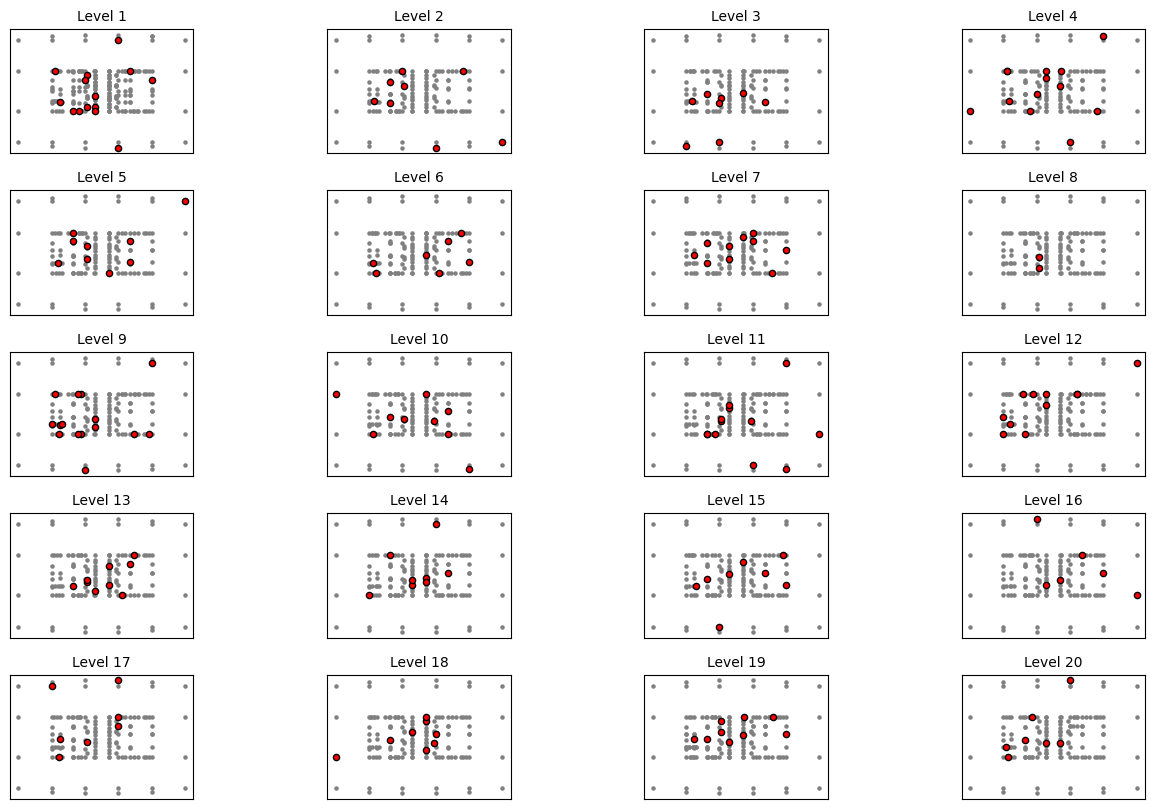

In [18]:
selected_ids = np.array(selected_ids)

# Plot
plot_scatter_by_z_levels(filtered_coord, matched_rows[:,0])

In [14]:
import numpy as np
from collections import defaultdict

# Group rows by Z (last column)
groups = defaultdict(list)
for row in matched_rows:
    z = row[-1]
    groups[z].append(row)

# Select up to 5 rows per Z and collect their IDs
selected_ids = []
for z, rows in groups.items():
    selected = rows[:5]  # Select first 5 (or fewer if less than 5 available)
    selected_ids.extend(row[0] for row in selected)

# Optionally convert to array or save to file
selected_ids = np.array(selected_ids)

# Print or return result
print("Selected sensor IDs (max 5 per Z):")
print(selected_ids)

Selected sensor IDs (max 5 per Z):
['28' '966' '2013' '2247' '2320' '52' '519' '1584' '2639' '2640' '77'
 '541' '775' '1619' '2165' '87' '321' '98' '331' '1971' '2305' '2465'
 '124' '357' '589' '590' '1293' '145' '148' '381' '852' '1316' '162' '391'
 '1098' '1327' '1744' '186' '1121' '1757' '2558' '4445' '233' '1399'
 '3796' '3836' '3849' '236' '1417' '1419' '1456' '1888' '250' '1520'
 '1544' '2318' '2768' '345' '1281' '1657' '2574' '2745' '408' '872' '2001'
 '2184' '2488' '429' '1803' '1871' '2145' '2253' '443' '907' '1377' '1380'
 '1776' '451' '454' '688' '1154' '2087' '510' '973' '1550' '2030' '2384'
 '602' '1696' '1704' '2692' '2900' '1002' '2071' '2168' '3356' '3456']


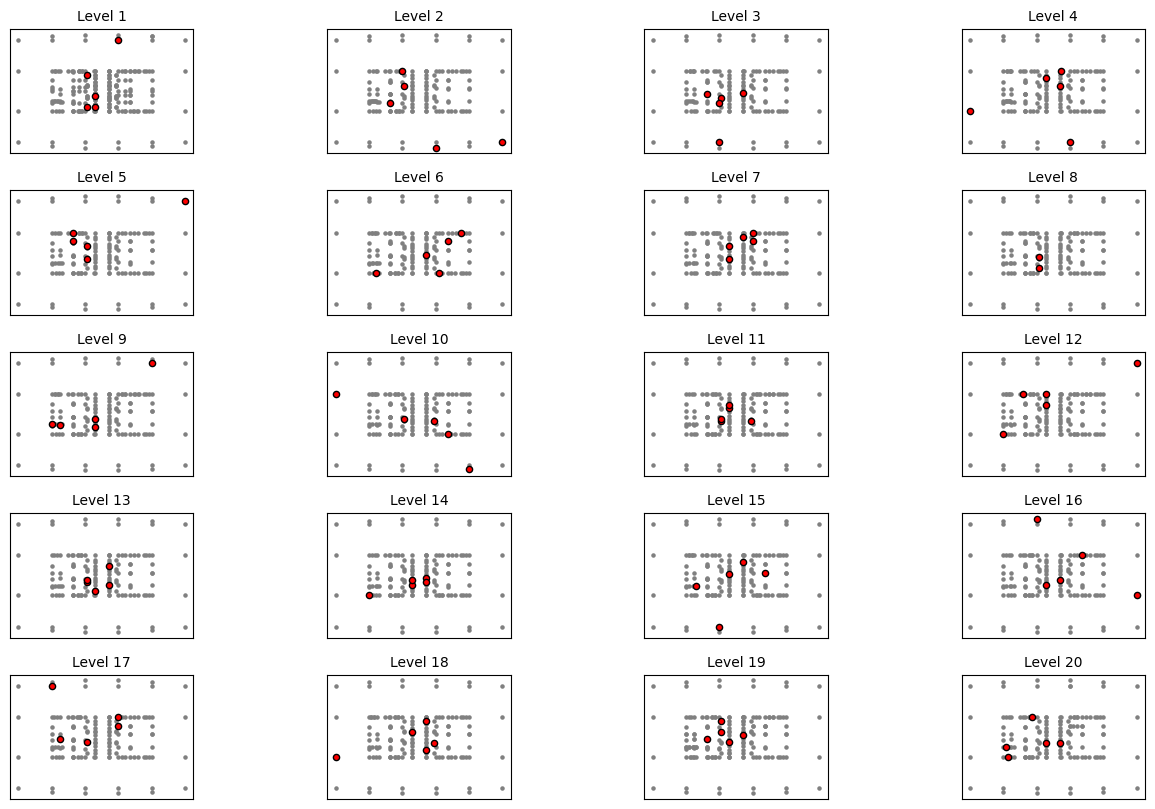

In [15]:
selected_ids = np.array(selected_ids)

# Plot
plot_scatter_by_z_levels(filtered_coord, selected_ids)

# 2 - Model training

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

Importing the dataset

In [ ]:
# Path to the .csv file
path = r'dataset\combined_dataset.csv'
X = pd.read_csv(path)
# first 5 rows of the data
X.head()

,0,1,2,3,4,5,6,7,8,9,...,335,336,337,338,339,340,341,342,343,344
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000507,0.000314,0.000416,...,2.779712e-05,2.801599e-05,2.912481e-05,0.000118,0.000145,3.702822e-05,7.157900e-05,0.000035,4.396142e-05,7.178028e-05
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001601,0.001099,0.001397,...,9.221750e-05,9.276431e-05,9.127350e-05,0.000324,0.000446,1.316673e-04,2.385007e-04,0.000100,1.386772e-04,2.413683e-04
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000006,0.000002,0.000002,...,4.610898e-07,6.497431e-07,7.605435e-07,0.000002,0.000002,8.503349e-07,4.675817e-07,0.000001,3.849757e-08,1.422550e-07
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000762,0.000499,0.000654,...,4.384855e-05,4.402273e-05,4.427402e-05,0.000169,0.000225,5.882268e-05,1.120361e-04,0.000054,6.826226e-05,1.133653e-04
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000062,0.000036,0.000049,...,3.303946e-06,3.917551e-06,4.541211e-06,0.000015,0.000018,5.192562e-06,8.630968e-06,0.000006,5.497961e-06,8.705674e-06


In [ ]:
print('Number of datapoints :', X.shape[0])

Number of datapoints : 5000


In [ ]:
# Path to the .csv file
path = r'dataset\dataset_info.csv'
y = pd.read_csv(path)
# first 5 rows of the data
y.head()

,ZONE 1,ZONE 2,ZONE 3
0,0.35,0.70,0.55
1,0.80,0.60,0.50
2,0.00,0.15,0.10
3,0.50,0.20,0.55
4,0.05,0.10,0.40


Preprocessing

In [ ]:
print('shape of input :', X.shape)
print('shape of output :', y.shape)

shape of input : (5000, 345)
shape of output : (5000, 3)


In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('shape of train set :', X_train.shape)
print('shape of test set :', X_test.shape)

shape of train set : (4000, 345)
shape of test set : (1000, 345)


In [ ]:
# Normalize the features and targets
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [ ]:
# Define the input layer
input_layer = Input(shape=(X.shape[1],))

# Define the dense layers
dense_1 = Dense(300, activation='relu')(input_layer)
dense_2 = Dense(200, activation='relu')(dense_1)
dense_3 = Dense(100, activation='relu')(dense_2)

# Define the output layer with 3 outputs between 0 and 1 (using sigmoid)
output = Dense(3, activation='sigmoid', name='output')(dense_3)

# Create the model
model = Model(inputs=input_layer, outputs=output)

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 345)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       103,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,403 (720.32 KB)

 Trainable params: 184,403 (720.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 100
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
# Train the model
history = model.fit(X_train_scaled,  y_train,
                    epochs=epochs, batch_size=32, validation_split=0.2)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5936 - loss: 0.0527 - val_accuracy: 0.7175 - val_loss: 0.0298
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7318 - loss: 0.0304 - val_accuracy: 0.7163 - val_loss: 0.0271
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7388 - loss: 0.0265 - val_accuracy: 0.7250 - val_loss: 0.0261
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7433 - loss: 0.0245 - val_accuracy: 0.7287 - val_loss: 0.0232
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7495 - loss: 0.0241 - val_accuracy: 0.6775 - val_loss: 0.0260
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7409 - loss: 0.0233 - val_accuracy: 0.7500 - val_loss: 0.0216
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7664 - loss: 0.0219 - val_accuracy: 0.7638 - val_loss: 0.0191
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8010 - loss: 0.0182 - val_accu

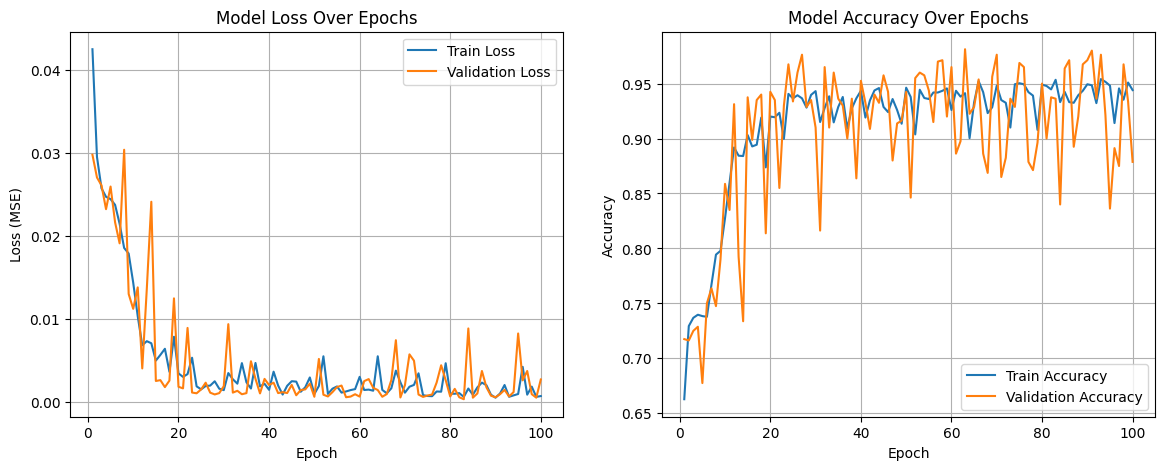

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(14,5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
predictions = model.predict(X_test_scaled)

# Assuming y_test is your true target values (shape: [num_samples, 3])
# Make sure y_test is a NumPy array
y_test_array = np.array(y_test)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({
    'True_1': y_test_array[:, 0],
    'Pred_1': predictions[:, 0],
    'True_2': y_test_array[:, 1],
    'Pred_2': predictions[:, 1],
    'True_3': y_test_array[:, 2],
    'Pred_3': predictions[:, 2],
})

print(comparison_df.head(10))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
   True_1    Pred_1  True_2    Pred_2  True_3    Pred_3
0    0.40  0.395124    0.30  0.240583    0.65  0.646737
1    0.85  0.841186    0.70  0.505786    0.45  0.444479
2    0.15  0.149475    0.35  0.324683    0.25  0.252317
3    0.15  0.147925    0.60  0.585903    0.65  0.649507
4    0.55  0.550667    0.15  0.076334    0.70  0.698809
5    0.65  0.650693    0.10  0.041606    0.85  0.854462
6    0.80  0.793066    0.70  0.542351    0.45  0.441108
7    0.70  0.695673    0.35  0.203803    0.30  0.311370
8    0.50  0.500006    0.00  0.013997    0.10  0.095875
9    0.00  0.008793    0.30  0.239493    0.65  0.650060
